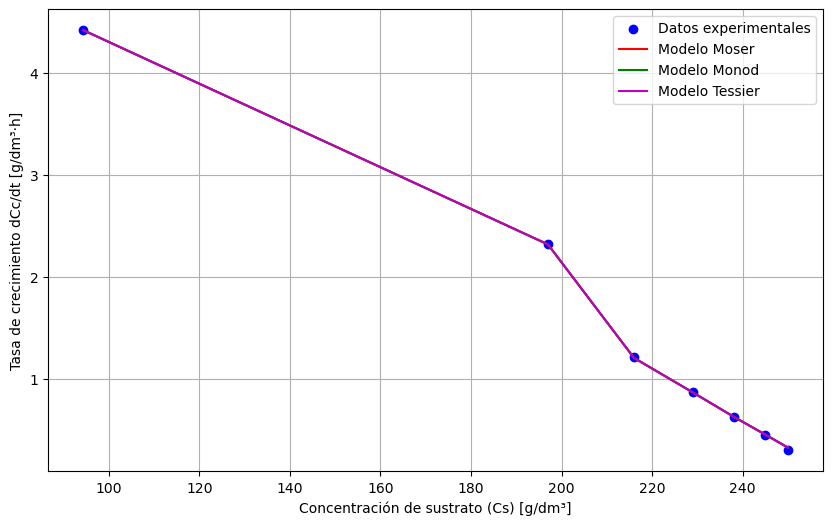


Parámetros estimados - Moser:
umax = 0.3271, ks = 15.9864, lambda = 1.5502

Parámetros estimados - Monod:
umax = 0.3284, ks = 1.6943

Parámetros estimados - Tessier:
umax = 0.3258, k = 20.4074


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Datos experimentales
T_exp = np.array([0, 1, 2, 3, 4, 6, 8])  # Tiempo en horas
C_C_exp = np.array([1, 1.39, 1.93, 2.66, 3.7, 7.12, 13.7])  # Biomasa (g/dm³)
C_S_exp = np.array([250, 245, 238, 229, 216, 197, 94.4])  # Sustrato (g/dm³)
dCdt_exp = np.array([0.30, 0.45, 0.63, 0.87, 1.21, 2.32, 4.42])  # dC_C/dt (g/dm³·h)

# Modelo de Moser
def moser_model(params, C_S, C_C):
    umax, ks, lam = params
    return (umax * C_C) / (1 + ks * C_S**-lam)

# Ajuste del modelo de Moser
params0 = [0.3, 16, 1]
res_moser = minimize(lambda p: np.sum((moser_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
umax_m, ks_m, lam_m = res_moser.x
rg_moser = moser_model(res_moser.x, C_S_exp, C_C_exp)

# Modelo de Monod
def monod_model(params, C_S, C_C):
    umax, ks = params
    return (umax * C_S * C_C) / (ks + C_S)

# Ajuste del modelo de Monod
params0 = [0.3, 16]
res_monod = minimize(lambda p: np.sum((monod_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
umax_monod, ks_monod = res_monod.x
rg_monod = monod_model(res_monod.x, C_S_exp, C_C_exp)

# Modelo de Tessier
def tessier_model(params, C_S, C_C):
    umax, k = params
    return umax * (1 - np.exp(-C_S / k)) * C_C

# Ajuste del modelo de Tessier
params0 = [0.3, 50]
res_tessier = minimize(lambda p: np.sum((tessier_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
umax_t, k_t = res_tessier.x
rg_tessier = tessier_model(res_tessier.x, C_S_exp, C_C_exp)

# Gráficos
plt.figure(figsize=(10, 6))
plt.scatter(C_S_exp, dCdt_exp, color='b', label='Datos experimentales')
plt.plot(C_S_exp, rg_moser, 'r-', label='Modelo Moser')
plt.plot(C_S_exp, rg_monod, 'g-', label='Modelo Monod')
plt.plot(C_S_exp, rg_tessier, 'm-', label='Modelo Tessier')
plt.xlabel('Concentración de sustrato (Cs) [g/dm³]')
plt.ylabel('Tasa de crecimiento dCc/dt [g/dm³·h]')
plt.legend()
plt.grid()
plt.show()

# Mostrar valores estimados
print("\nParámetros estimados - Moser:")
print(f"umax = {umax_m:.4f}, ks = {ks_m:.4f}, lambda = {lam_m:.4f}")

print("\nParámetros estimados - Monod:")
print(f"umax = {umax_monod:.4f}, ks = {ks_monod:.4f}")

print("\nParámetros estimados - Tessier:")
print(f"umax = {umax_t:.4f}, k = {k_t:.4f}")


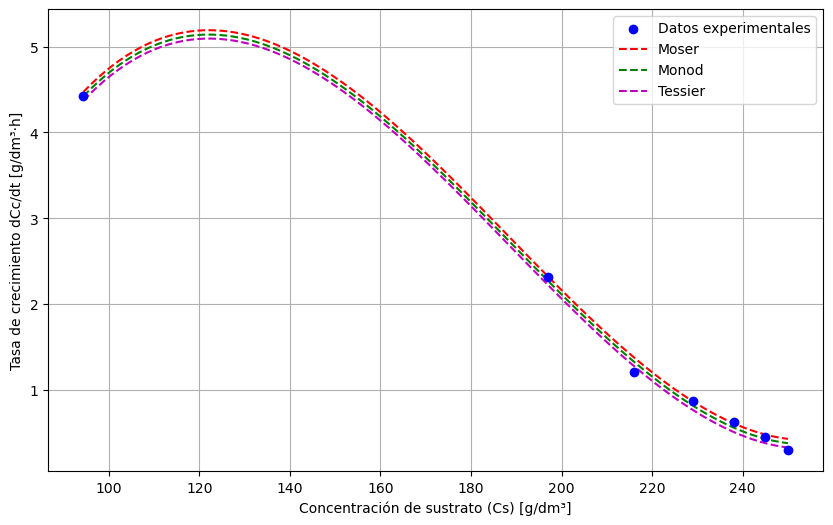

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Datos experimentales
T_exp = np.array([0, 1, 2, 3, 4, 6, 8])  # Tiempo en horas
C_C_exp = np.array([1, 1.39, 1.93, 2.66, 3.7, 7.12, 13.7])  # Biomasa (g/dm³)
C_S_exp = np.array([250, 245, 238, 229, 216, 197, 94.4])  # Sustrato (g/dm³)
dCdt_exp = np.array([0.30, 0.45, 0.63, 0.87, 1.21, 2.32, 4.42])  # dC_C/dt (g/dm³·h)

# Modelo de Moser
def moser_model(params, C_S, C_C):
    umax, ks, lam = params
    return (umax * C_C) / (1 + ks * C_S**-lam)

# Ajuste del modelo de Moser
params0 = [0.3, 16, 1]
res_moser = minimize(lambda p: np.sum((moser_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
rg_moser = moser_model(res_moser.x, C_S_exp, C_C_exp)

# Modelo de Monod
def monod_model(params, C_S, C_C):
    umax, ks = params
    return (umax * C_S * C_C) / (ks + C_S)

# Ajuste del modelo de Monod
params0 = [0.3, 16]
res_monod = minimize(lambda p: np.sum((monod_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
rg_monod = monod_model(res_monod.x, C_S_exp, C_C_exp)

# Modelo de Tessier
def tessier_model(params, C_S, C_C):
    umax, k = params
    return umax * (1 - np.exp(-C_S / k)) * C_C

# Ajuste del modelo de Tessier
params0 = [0.3, 50]
res_tessier = minimize(lambda p: np.sum((tessier_model(p, C_S_exp, C_C_exp) - dCdt_exp)**2), params0)
rg_tessier = tessier_model(res_tessier.x, C_S_exp, C_C_exp)

# Interpolación para suavizar curvas
C_S_interp = np.linspace(min(C_S_exp), max(C_S_exp), 100)

# Suavizado con regresión polinómica
degree = 3
poly_moser = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(C_S_exp.reshape(-1, 1), rg_moser)
rg_moser_smooth = poly_moser.predict(C_S_interp.reshape(-1, 1))

poly_monod = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(C_S_exp.reshape(-1, 1), rg_monod)
rg_monod_smooth = poly_monod.predict(C_S_interp.reshape(-1, 1))

poly_tessier = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(C_S_exp.reshape(-1, 1), rg_tessier)
rg_tessier_smooth = poly_tessier.predict(C_S_interp.reshape(-1, 1))

# Suavizado con Gaussian Process Regression
kernel = C(1.0, (1e-2, 1e2)) * RBF(10, (1e-2, 1e2))

gpr_moser = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(C_S_exp.reshape(-1, 1), rg_moser)
rg_moser_gpr = gpr_moser.predict(C_S_interp.reshape(-1, 1))

gpr_monod = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(C_S_exp.reshape(-1, 1), rg_monod)
rg_monod_gpr = gpr_monod.predict(C_S_interp.reshape(-1, 1))

gpr_tessier = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(C_S_exp.reshape(-1, 1), rg_tessier)
rg_tessier_gpr = gpr_tessier.predict(C_S_interp.reshape(-1, 1))

# Gráficos mejorados
plt.figure(figsize=(10, 6))
plt.scatter(C_S_exp, dCdt_exp, color='b', label='Datos experimentales', zorder=3)

# Regresión polinómica (líneas punteadas)
plt.plot(C_S_interp, rg_moser_smooth+0.05, 'r--', label='Moser')
plt.plot(C_S_interp, rg_monod_smooth, 'g--', label='Monod')
plt.plot(C_S_interp, rg_tessier_smooth-0.05, 'm--', label='Tessier')


plt.xlabel('Concentración de sustrato (Cs) [g/dm³]')
plt.ylabel('Tasa de crecimiento dCc/dt [g/dm³·h]')
plt.legend()
plt.grid()
plt.show()
